# CMA for Swing
The code for this is based on Christian Igel's "CMA Cart Pole" code, distributed in the Advanced Topics in Machine Learning, 2018.

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cma
import math
import rpyc
from IPython import display
import time
from sklearn.linear_model import LinearRegression
import pickle

## Robot Controls
The robot controller is described in the robot_controler notebook. With more time, an improvement could be moving this blcok into a .py file and importing it instead.

In [6]:
class RobotController:
    """
    The robot controller class.
    """
    def __init__(self, connection):
        motor_module = connection.modules['ev3dev2.motor']
        self.motors = [motor_module.LargeMotor('outB'), motor_module.LargeMotor('outC')]
        sensors = conn.modules['ev3dev2.sensor.lego'] 
        self.gyro = sensors.GyroSensor('in2')
        
        self.motors[0].stop_action = 'hold'
        self.motors[1].stop_action = 'coast'
        
        self.up_position_degrees = -90 # position of legs fully in front
        self.maxspeed = 80 # maximum speed of leg movement
        self.minspeed = 3 # minimum speed of leg movement
        self.angle_normalizer = 0.01
        self.rate_normalizer = 0.01
        
        
    
    def reset(self):
        """ resets the robot, performs calibration and maintainance, return when robot is reset.
        Called at the start of each episode"""
        # move legs to base position
        self._move_motors_to_pos(0, 20)
        self._wait_until_no_standstill(tolerance = 0.05)
        _, angle = self.get_rate_and_angle()
        if abs(angle) >= 0.04:
            # drifted pretty far, recalibrate
            self._wait_until_no_standstill(tolerance = 0.01)
            self._calibrate_gyro()
            return
    
    def get_rate_and_angle(self):
        """ returns the rate and angle of the robot movement"""
        angle, rate = self.gyro.rate_and_angle
        return (rate * self.rate_normalizer, angle * self.angle_normalizer)

    def get_current_leg_pos(self):
        """ returns the curent leg pos, on a [-1, 1] interval"""
        return self.motors[0].position /  self.up_position_degrees
    
    def move_legs(self, pos):
        """ instructs the robot where to move its legs to, on a [-1, 1] interval. Function returns immediatly."""
        pos = max(-1., min(pos, 1.))
        pos_now = self.get_current_leg_pos()
        
        s = abs(pos - pos_now) / 2 *  self.maxspeed
        s = max(self.minspeed, min(s,  self.maxspeed))
        
        self._move_motors_to_pos(pos, s)
        return
    
    def _move_motors_to_pos(self, pos, speed):
        """
        moves the motors to a position [-1, 1] at speed [0,100].
        """
        assert -1. <= pos <= 1.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        assert 0. <= speed <= 100.,\
                    "{} is an invalid position, must be between -1 and 1 (inclusive)".format(pos)
        
        self.motors[0].on_to_position(speed, position=pos*self.up_position_degrees, brake=True, block=False) # moves motors, non blocking.
        return
            
            
    def _calibrate_gyro(self):
        print('calibrating gyro')
        self.gyro.mode='GYRO-CAL'
        time.sleep(1)
        self.gyro.mode="GYRO-ANG"
        
    def _wait_until_no_standstill(self, tolerance=0.01):
        """
        waits until the gyro acceleration does not change for 3 seconds
        """
        print("Waiting to stand still.")
        change = 9999
        while abs(change) > tolerance: 

            rates = []
            times = []
            # sample for one second
            t0 = t = time.time()
            while t - t0 < 3:
                _, rate = self.gyro.rate_and_angle
                rates.append(rate)
                t = time.time()
                times.append(t)


            # check change in accel with linreg
            rates = abs(np.array(rates)) # take absolute rates so swinging doesnt cancel each other out
            times = np.array(times)
            lr = LinearRegression()
            lr.fit(times[:, np.newaxis], rates)  
            change = lr.coef_

        return

class RobotControllerVerboseWrapper(RobotController):
    """
    Wrapper / decorator for the robot controller to add verbose logging
    for design pattern see https://github.com/faif/python-patterns/blob/master/structural/decorator.py
    """
    def __init__(self, robotController):
        self.wrapped = robotController
        self.last_move = time.time()
        
    def reset(self):
        return self.wrapped.reset()
    
    def get_rate_and_angle(self):
        return self.wrapped.get_rate_and_angle()
    
    def get_current_leg_pos(self):
        return self.wrapped.get_current_leg_pos()
    
    def move_legs(self, pos):
        print("Moving legs to {}, time since last move {}".format(pos, time.time() - self.last_move))
        self.last_move = time.time()
        return self.wrapped.move_legs(pos)

class RobotControllerExceptionWrapper(RobotController):
    """
    Wrapper / decorator for the robot controller to handle time out exceptions
    for design pattern see https://github.com/faif/python-patterns/blob/master/structural/decorator.py
    """
    def __init__(self, robotController):
        self.wrapped = robotController
        
    def reset(self):
        try:
            return self.wrapped.reset()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.reset()
    
    def get_rate_and_angle(self):
        try:
            return self.wrapped.get_rate_and_angle()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.get_rate_and_angle()
    
    def get_current_leg_pos(self):
        try:
            return self.wrapped.get_current_leg_pos()
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.get_current_leg_pos()
    
    def move_legs(self, pos):
        try:
            return self.wrapped.move_legs(pos)
        except TimeoutError:
            print('TimeoutError occured! retrying...')
            time.sleep(3)
            return self.move_legs(pos)
            
        

# Setup
As usual, connection is made to the robot, in addition, we initialize the RobotController class and define helper functions for trainable parameters.

In [49]:
try:
    ROBOT_HOSTNAME = "ev3dev.local"
    conn = rpyc.classic.connect(ROBOT_HOSTNAME)
    conn.execute("print('Hello Slave. I am your master!')")
except:
    raise Exception('No conection to rpyc server on robot possible! Is the robot conneced? Is the rpyc server started?')
    


In [50]:
weights = []
timestep = []
rewards = []

rc = RobotControllerExceptionWrapper(RobotController(conn))

In [7]:
# Helper functions for setting the parameters of the neural network
def number_of_trainable_parameters(session):
    variables_names = [v.name for v in tf.trainable_variables()]
    values = session.run(variables_names)    
    number_of_parameters = 0
    for v in values:
        number_of_parameters += v.size
    return number_of_parameters

def set_trainable_parameters(session, parameter_vector):
    assert number_of_trainable_parameters(session) == parameter_vector.size, \
      'number of parameters do not match: %r vs. %r' % (number_of_trainable_parameters(session), parameter_vector.size)
    variables_names = [v.name for v in tf.trainable_variables()]
    values = session.run(variables_names) 
    idx = 0
    for k, v in zip(tf.trainable_variables(), values):    
        new_value = parameter_vector[idx:idx + v.size].reshape(v.shape)
        k.load(new_value, session)  # load does not add a new node to the graph
        idx += v.size

## Swing motion function
This is the function we attempt to optimize. It recieves data about the current state and feeds this into a neural network (defined later) to get an action, which it performs. During this, it keeps track of the maximal absolute rate observed to be able to pass a final reward back 

In [40]:
# Simple evaluation function, just considering a single (random) start state
def swing_motion(x, sess, duration=30):
    # set params to NN
    set_trainable_parameters(sess, x)
    
    # reset swing
    rc.reset()
    
    # simulate
    reward = 0
    pos = 0
    starttime = time.time()
    rate, angle = rc.get_rate_and_angle()
    while time.time()-starttime < duration :

        state = np.array([rate, angle, pos])
        
        pos = sess.run(action, {inputs: state.reshape(1,*state.shape)})[0][0]
        
        rc.move_legs(pos)
        
        rate, angle = rc.get_rate_and_angle()
        reward = max(reward, abs(rate))
    
    # log rewards of session
    print("total reward for session: ",reward)
    weights.append(x)
    timestep.append(starttime)
    rewards.append(reward)
    return -reward

In [13]:
# Neural network parameters
state_space_dimension = 3
number_of_actions = 1
number_of_hidden_neurons = 2 # currently unused, becomes relevant if the hidden layer is reimplemented.


## Neural network and CMA-ES
Here, we define the policy network, which is very simple for our implementation, but with this setup it can easily be expanded to include hidden layers, or (with slightly more work) be recurrent.  
Afterwards, a session is started and we run the CMA minimizer, using our guess for initial weights.

In [15]:
tf.reset_default_graph()

# Define policy network mapping state to action
with tf.name_scope('policy_network'):
    inputs = tf.placeholder(shape=[1, state_space_dimension],dtype=tf.float32) 
    #hidden = tf.layers.dense(inputs, number_of_hidden_neurons, activation=tf.tanh, use_bias=True)
    action = tf.layers.dense(inputs, number_of_actions, activation=tf.tanh, use_bias=True)

# Do the learning
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    sess.graph.finalize()  # graph is read-only after this statement
    #initial_weights = np.random.normal(0, 0.1, number_of_trainable_parameters(sess))
    # best guess for starting weights: 
    #     large weight to move in the direction of the rate
    #     smaller negative weight to move less extreme when on a far end
    #     small bias of 0.2 to start the movement
    initial_weights = np.array([10, -5, -1, 0.2]) 
    res = cma.fmin(swing_motion, initial_weights, 1, {'timeout': 14 * 60**2, 'ftarget':-4.,}, args=([sess]), restart_from_best=True)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=584557, Mon Jan 14 20:13:46 2019)
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.51
Waiting to stand still.
total reward for session:  0.46
Waiting to stand still.
total reward for session:  0.56
Waiting to stand still.
total reward for session:  0.56
Waiting to stand still.
total reward for session:  0.46
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.19
Waiting to stand still.
total reward for session:  0.14
Waiting to stand still.
total reward for session:  0.06
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -5.600000000000001e-01 1.0e+00 8.50e-01  7e-01  9e-01 6:35.7
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.25
Waiting to stand still.
total reward for session:  0.11
Waiting to stand still.
total reward for session:  0.36
Waiting to stand still.
W

total reward for session:  0.29
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.54
Waiting to stand still.
total reward for session:  0.53
Waiting to stand still.
total reward for session:  0.62
Waiting to stand still.
total reward for session:  0.47000000000000003
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.6
Waiting to stand still.
total reward for session:  0.2
   13    104 -6.200000000000000e-01 2.4e+00 5.69e-01  3e-01  7e-01 80:11.8
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.25
Waiting to stand still.
total reward for session:  0.76
Waiting to stand still.
total reward for session:  0.61
Waiting to stand still.
total reward for session:  0.48
Waiting to stand still.
total reward for session:  0.63
Waiting to stand still.
total reward for session:  0.62
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for ses

total reward for session:  0.72
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.41000000000000003
Waiting to stand still.
total reward for session:  0.58
Waiting to stand still.
total reward for session:  0.48
Waiting to stand still.
total reward for session:  0.54
Waiting to stand still.
total reward for session:  0.75
Waiting to stand still.
total reward for session:  0.53
   26    208 -7.500000000000000e-01 4.5e+00 1.00e+00  4e-01  1e+00 158:30.1
Waiting to stand still.
total reward for session:  0.77
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.5
Waiting to stand still.
total reward for session:  0.49
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.39
Waiting to stand still.
total reward for session:  0.5700000000000001
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.84
Waiting to stand still.
tota

total reward for session:  0.75
Waiting to stand still.
total reward for session:  0.45
Waiting to stand still.
total reward for session:  0.8300000000000001
Waiting to stand still.
total reward for session:  1.01
   38    304 -1.370000000000000e+00 4.9e+00 6.85e-01  3e-01  8e-01 234:49.7
Waiting to stand still.
total reward for session:  0.85
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.63
Waiting to stand still.
total reward for session:  1.02
Waiting to stand still.
total reward for session:  0.5700000000000001
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  2.5500000000000003
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.48
Waiting to stand still.
total reward for session:  0.77
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.6900000000000001
   39    312 -2.550000000000000e+00 5.4e+00 6.42e-01  3e

Waiting to stand still.
calibrating gyro
total reward for session:  0.79
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.52
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.62
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.04
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.7000000000000001
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.54
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.28
   50    400 -1.620000000000000e+00 7.7e+00 3.93e+00  1e+00  5e+00 317:37.9
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.71
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.93
Waiting to stand still.
total reward for session:  1.17
Waiti

calibrating gyro
total reward for session:  0.42
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.81
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.41
   60    480 -2.030000000000000e+00 8.4e+00 4.05e+00  9e-01  5e+00 402:40.5
Waiting to stand still.
total reward for session:  1.25
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.88
Waiting to stand still.
total reward for session:  1.9000000000000001
Waiting to stand still.
total reward for session:  0.45
Waiting to stand still.
total reward for session:  0.75
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.56
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  2.17
Waiting to stand still.
TimeoutError occured! retrying...
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.

total reward for session:  0.46
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.6400000000000001
Waiting to stand still.
total reward for session:  0.4
Waiting to stand still.
total reward for session:  0.41000000000000003
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.59
   70    560 -1.740000000000000e+00 2.0e+01 4.70e+00  1e+00  7e+00 494:07.1
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.34
Waiting to stand still.
total reward for session:  0.47000000000000003
Waiting to stand still.
total reward for session:  0.45
Waiting to stand still.
total reward for session:  1.04
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  0.41000000000000003
Waiting to stand still.
total reward for session:  1.67
Waiting to stand still.
Waiting to stand still.
calibrating gyro
total reward for session:  1.1
Waiting to sta

EOFError: connection closed by peer

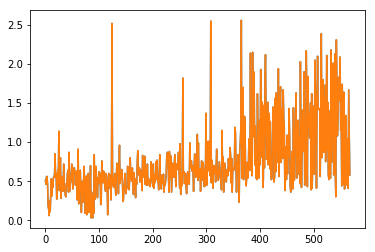

In [25]:
plt.plot(rewards)
plt.show()

In [34]:
pickle.dump({'rewards':rewards, 'times':timestep, 'weights': weights}, open('CMA_results.pickl', 'wb'))

# Play best solution
Since the weights from each iteration is saved, we can replay them easily.

In [54]:
dmp = pickle.load(open('./cma_results/CMA_results.pickl', 'rb'))
weights = dmp['weights']
timestep = dmp['times']
rewards = dmp['rewards']

In [56]:
i = np.argmax(rewards)
x_opt = weights[i]
x_opt

array([ 14.32664285, -11.95811443,  -6.27011603,   1.2407833 ])

In [68]:
# final CMA cluster center
x_opt = np.array([25.9736008064, -22.9594373082, -11.10449353, 6.31055445259])

In [69]:
with tf.Session() as sess:
    sess.run(init)
    sess.graph.finalize()
    try:
        swing_motion(x_opt, sess, duration=60)
    except AttributeError:
        pass
    rc.reset()

Waiting to stand still.
total reward for session:  3.29
Waiting to stand still.
TimeoutError occured! retrying...
Waiting to stand still.
TimeoutError occured! retrying...
Waiting to stand still.
Waiting to stand still.
calibrating gyro
